In [1]:
%matplotlib inline

import os
import sys
import pickle

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import probplot
from scipy.stats import kstest
from scipy.stats import uniform
from scipy.interpolate import CubicSpline
import yaml

In [11]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)
plt.rc('font', family='serif')

In [12]:
def generate_data_from_pred_int(int_lim, pred_int, pred_int_grid, time_limit):
    """
    This function samples a data set from the predictive intesity function
    """
    num_trials = pred_int_grid.shape[0]
    events = []
    num_test_grid_points = pred_int_grid.shape[1]
    num_events_cumsum_test = np.arange(0, num_test_grid_points * num_trials + num_test_grid_points, num_test_grid_points)
    for n in range(num_trials):
        num_candidates = np.random.poisson(int_lim * time_limit)
        candidates = np.random.uniform(0, time_limit, num_candidates)
        candidates = np.sort(candidates)
        cs = CubicSpline(pred_int_grid[n], pred_int[num_events_cumsum_test[n]: num_events_cumsum_test[n + 1]])
        pred_cands = cs(candidates)
        r = np.random.uniform(0, 1, num_candidates)
        accepted_candidates = candidates[r < pred_cands / int_lim]
        events.append(accepted_candidates)
    return events

In [13]:
# set path and file names
results_folder = '../Experiments/calculate_predictive_intensity/results/neurons/'
input_file = 'input.yml'
data_file = 'data.p'
results_file = 'res.p'
pred_int_file = 'pred_int_res.p'

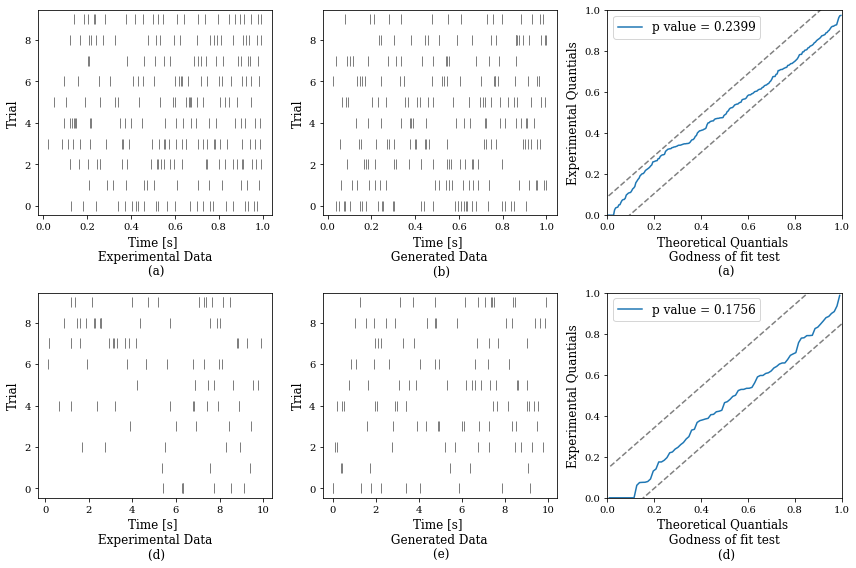

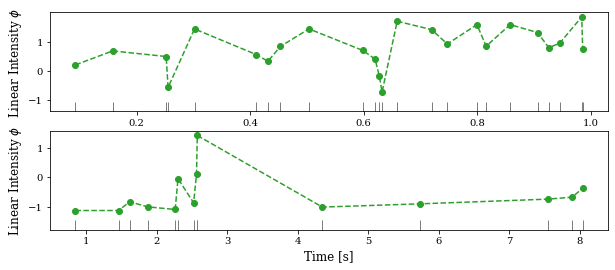

In [17]:
fig_1, axs_1 = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
fig_2, axs_2 = plt.subplots(nrows=2, ncols=1, figsize=(10,4))
l = 0
panels_order = [['(a)', '(b)', '(c)'], ['(d)', '(e)', '(f)']]
for fold in os.walk(results_folder):
    if 'ipynb' not in fold[0] and 'dataset' in fold[0]:
        res_input_file = os.path.join(fold[0], input_file)
        res_data_file = os.path.join(fold[0], data_file)
        res_results_file = os.path.join(fold[0], results_file)
        res_pred_int_file = os.path.join(fold[0], pred_int_file)
        
        with open(res_data_file, 'rb') as f:
            dat = pickle.load(f)
        with open(res_input_file, 'rb') as stream:
            config = yaml.safe_load(stream)        
        num_trials = len(dat)
        num_events = [len(dat[n]) for n in range(num_trials)]
        num_events = [0] + num_events
        num_events_cumsum = np.cumsum(np.array(num_events))
            
        num_induced_points = config['num_inducing_points']
        num_integration_points = config['num_integration_points']
        hypers_array = [0, 0, 0, 0]
        T = dat[0][-1] + 0.5
            
        with open(res_results_file, 'rb') as f:
            with open(res_results_file, 'rb') as f:
                    LB_list, mu_g_X, mu_g2_X, hyper_params_list, \
                    induced_points, integration_points, Kss_inv, ks_int_points, \
                    ks_X, real_events, Sigma_g_s, mu_g_s, lmbda_star_q1, alpha_q1, \
                    beta_q1 = pickle.load(f)
            
        with open(os.path.join(fold[0], pred_int_file), 'rb') as f:
            test_grid, mean_lmbda_pred, var_lmbda_pred = pickle.load(f)

        dt = test_grid[0, 2] - test_grid[0, 1]
        taus = []
        num_test_grid_points = test_grid.shape[1]
        num_events_cumsum_test = np.arange(0, num_test_grid_points * num_trials + num_test_grid_points, num_test_grid_points)
        for n in range(num_trials):
            compensator_vi_trial = np.zeros(dat[n].shape[0])
            for j, point in enumerate(dat[n]): 
                i = np.argmin(point > test_grid[n])
                compensator_vi_trial[j] = mean_lmbda_pred[num_events_cumsum_test[n]: num_events_cumsum_test[n + 1]][:i].sum() * dt
            tau_vi = compensator_vi_trial[1:] - compensator_vi_trial[:-1]
            taus.append(tau_vi)
        tau_vi_flat = np.hstack(taus)
        z_vi_flat = 1. - np.exp(-tau_vi_flat)

        n = len(tau_vi_flat)
        k = np.arange(1, n + 1)
        b_k = (k - 0.5) / n
        b_k_l = b_k - 1.36  / np.sqrt(n)
        b_k_u = b_k + 1.36 / np.sqrt(n)

        res_vi_uni = probplot(z_vi_flat[z_vi_flat>-1], plot=None, dist=uniform)
    
        num_trials = len(dat)
        gen_data = generate_data_from_pred_int(lmbda_star_q1 / num_trials, mean_lmbda_pred, test_grid, config['time_bound'])
        res_kstest = kstest(z_vi_flat, 'uniform')

        axs_1[l][2].plot(res_vi_uni[0][0], res_vi_uni[0][1], label='p value = %.4f' %round(res_kstest[1], 4))
        axs_1[l][2].plot(k /n, b_k_u, '--', color='grey')
        axs_1[l][2].plot(k /n, b_k_l, '--', color='grey')
        axs_1[l][2].set_xlabel(f'Theoretical Quantials \n Godness of fit test \n {panels_order[l][0]}')
        axs_1[l][2].set_ylabel('Experimental Quantials')
        axs_1[l][2].set_xlim((0,1))
        axs_1[l][2].set_ylim((0,1))
        axs_1[l][2].legend()

        for n in range(num_trials):
            axs_1[l][0].plot(dat[n], np.repeat(n, len(dat[n])), '|', color='C7', markersize=10)
            axs_1[l][1].plot(gen_data[n], np.repeat(n, len(gen_data[n])), '|', markersize=10, color='C7')
        axs_1[l][0].set_xlabel(f'Time [s] \n Experimental Data \n {panels_order[l][0]}')
        axs_1[l][0].set_ylabel('Trial')
        axs_1[l][1].set_xlabel(f'Time [s] \n Generated Data \n {panels_order[l][1]}')
        axs_1[l][1].set_ylabel('Trial')
        
        if '2c' in fold[0]:
            ind = 6
        else:
            ind = 8
        
        axs_2[l].plot(dat[ind], mu_g_X[num_events_cumsum[ind]: num_events_cumsum[ind+1]], '--o', color='#2ca02c')
        axs_2[l].plot(dat[ind], np.repeat(min(mu_g_X[num_events_cumsum[ind]: num_events_cumsum[ind+1]]) - 0.5, len(dat[ind])), '|', color='C7', markersize=10)
        axs_2[l].set_ylabel(r'Linear Intensity $\phi$')
        if l == 1:
            axs_2[l].set_xlabel('Time [s]')
        
        l += 1
fig_1.set_tight_layout(True)
plt.show()